In [50]:
import numpy as np
import pickle
import os
import tarfile

import matplotlib.pyplot as plt
import seaborn as sns

import wandb

from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms


In [58]:
# Extract cifar-100-python.tar.gz to separate data
with tarfile.open("cifar-100-python.tar.gz", 'r|gz') as f:
        f.extractall(path="./")
        f.close()

In [111]:
data = pickle.load(open(os.path.join("cifar-100-python", "train"), 'rb'), encoding='latin1')
X_train = data['data']
y_train = np.asarray(data['fine_labels'], np.int8)

data = pickle.load(open(os.path.join('cifar-100-python', 'test'), 'rb'), encoding='latin1')
X_test = data['data']
y_test = np.asarray(data['fine_labels'], np.int8)

In [112]:
# reshape
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)


In [97]:
X_train.shape

(50000, 32, 32, 3)

In [96]:
X_train = np.rollaxis(X_train,1,4)
X_test = np.rollaxis(X_test,1,4)

D:\Git\NSIETE\Zadanie 2\.env_zadanie2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

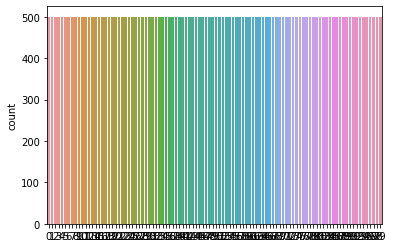

In [62]:
sns.countplot(y_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


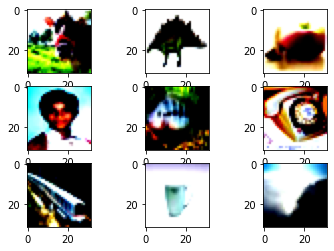

In [103]:
x_max,y_max = 3,3
offset = 0

f, axarr = plt.subplots(y_max,x_max)
for y in range(y_max):
    for x in range(x_max):
        axarr[y,x].imshow(X_train[y*y_max+x+offset])
# print(y_train[i])
# plt.imshow(np.rollaxis(X_train[i], 0, 3))

In [104]:
mean = X_train.mean(axis=(0,1,2), keepdims=True).astype(np.float32)
std = X_train.std(axis=(0,1,2), keepdims=True).astype(np.float32)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std


array([[[[-6.8521500e-09,  7.3909758e-09, -3.0052663e-09]]]],
      dtype=float32)

In [49]:
class CIFAR(Dataset):
    def __init__(self, X,y,transform=None):
        self.X=X
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        image = self.X[index]
        label = self.y[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

NameError: name 'Dataset' is not defined

In [ ]:
train_data = CIFAR(X_train,y_train,transform=transforms.ToTensor())
valid_data = CIFAR(X_test,y_test,transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_data,batch_size=128)
valid_loader = DataLoader(dataset=valid_data,batch_size=128)

In [106]:
class Net(nn.Module):
    def __init__(self, in_chanels, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)


        self.features = nn.Sequential(
            nn.Conv2d(in_chanels,64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.Conv2d(256,256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256,num_classes),
            nn.ReLU(True),

        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [118]:
model = Net(3,100)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [121]:
output = model.forward(torch.Tensor(X_train[:2]))

In [122]:
output.shape


torch.Size([2, 100])

[0, 1]